## Load dependencies

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('../')
sys.path.append('../src/')

In [19]:
import numpy as np
from pathlib import Path
import json
import matplotlib.pyplot as plt

from src.evaluate_lstm import EvaluateSimpleLSTM, EvaluateLSTMWithAttention
from src.utils import get_sequence_data, get_data
from src.evaluation_utils import evaluate_on_dataset

## Deepmind reference
Below are the reference values from DeepMind's experiments for the simple LSTM as well as for the attentional LSTM.

_Note:_ These results were obtained visually from the graph in the paper.

In [9]:
res_dm_lstm_inter = {'arithmetic__add_or_sub': 0.875,
                     'arithmetic__add_or_sub_in_base': 0.9,
                     'arithmetic__add_sub_multiple': .95,
                     'arithmetic__mul_div_multiple': .95,
                     'arithmetic__nearest_integer_root': .875,
                     'arithmetic__mul': 0.45,
                     'arithmetic__div': 0.78,
                     'arithmetic__simplify_surd':0.16,
                     'arithmetic__mixed': 0.62
                    }

res_dm_att_lstm_inter = {'arithmetic__add_or_sub': 0.875,
                         'arithmetic__add_or_sub_in_base': 0.925,
                         'arithmetic__add_sub_multiple': .89,
                         'arithmetic__mul_div_multiple': .91,
                         'arithmetic__nearest_integer_root': .9,
                         'arithmetic__mul': 0.55,
                         'arithmetic__div': 0.82,
                         'arithmetic__simplify_surd':0.08,
                         'arithmetic__mixed': 0.4
                        }

res_dm_lstm_extra = {'arithmetic__add_or_sub_big': 0.3,
                     'arithmetic__add_sub_multiple_longer': 0.55,
                     'arithmetic__mul_big': .225,
                     'arithmetic__mixed_longer': 0.1,
                     'arithmetic__mul_div_multiple_longer': 0.55,
                     'arithmetic__div_big':0.625
                    }

res_dm_att_lstm_extra = {'arithmetic__add_or_sub_big': 0.82,
                         'arithmetic__add_sub_multiple_longer': 0.22,
                         'arithmetic__mul_big': .31,
                         'arithmetic__mixed_longer': 0.02,
                         'arithmetic__mul_div_multiple_longer': 0.34,
                         'arithmetic__div_big':0.64
                        }

## Load datasets

In [14]:
job_ids = ['lstm-simple-epoch-1', 'lstm-simple-epoch-2', 'lstm-simple-epoch-3']

In [18]:
model_path = Path('../src/models/'  + job_ids[0])
settings_dict, input_texts, target_texts = get_data(model_path/'settings.json')
data_gen_pars, _, _ = get_sequence_data(settings_dict)

## Results
### Simple LSTM (1-3 epochs)

EPOCH 1


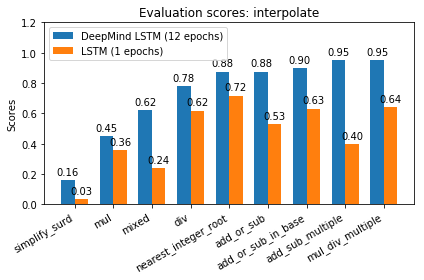

EPOCH 2


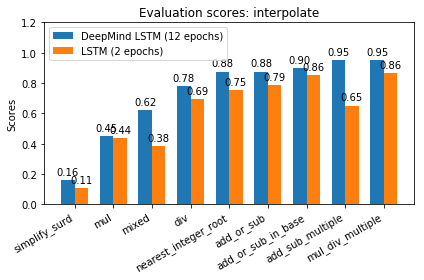

EPOCH 3


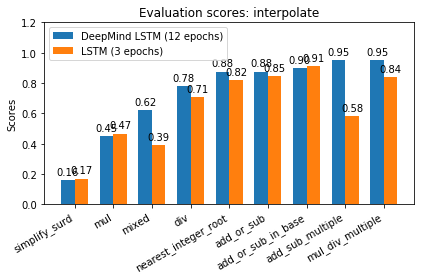

In [21]:
for epoch, job_id in enumerate(job_ids):
    model_path = Path('../src/models/'  + job_id)
    lstm_eval = EvaluateSimpleLSTM(model_path, data_gen_pars)
    print('EPOCH', epoch+1)
    exp_name = 'LSTM (%i epochs)' % (epoch+1)
    res, res_dm = evaluate_on_dataset(lstm_eval, input_texts, target_texts, 
                                      ['DeepMind LSTM (12 epochs)', exp_name],
                                      res_dm_lstm_inter, test_set='interpolate')

EPOCH 1


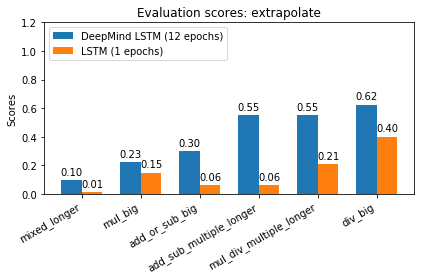

EPOCH 2


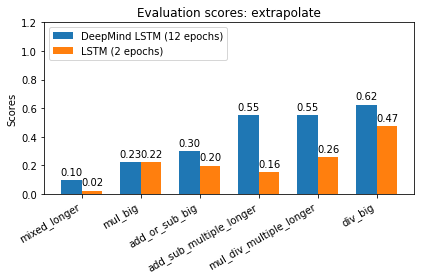

EPOCH 3


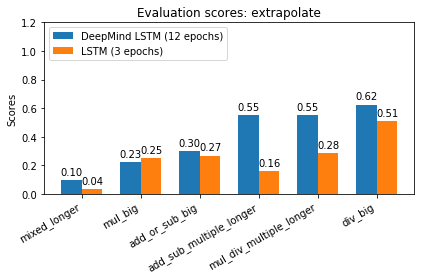

In [22]:
for epoch, job_id in job_ids.items():
    model_path = Path('../src/models/'  + job_id)
    lstm_eval = EvaluateSimpleLSTM(model_path, data_gen_pars)
    print('EPOCH', epoch)
    exp_name = 'LSTM (%i epochs)' % epoch
    res, res_dm = evaluate_on_dataset(lstm_eval, input_texts, target_texts, 
                                      ['DeepMind LSTM (12 epochs)', exp_name],
                                      res_dm_lstm_extra, test_set='extrapolate')

#### We can also test an indiviual string:

In [46]:
lstm_eval.predict_on_string('1 / 1')

'-6'

### Attentional LSTM

In [36]:
job_ids = ['lstm-attention-epoch-1']

In [37]:
model_path = Path('../src/models/'  + job_ids[0])
settings_dict, input_texts, target_texts = get_data(model_path/'settings.json')
data_gen_pars, _, _ = get_sequence_data(settings_dict)

EPOCH 0
19/19 [==============================] - 28s 1s/step - loss: 6.2805 - exact_match_metric: 0.0119


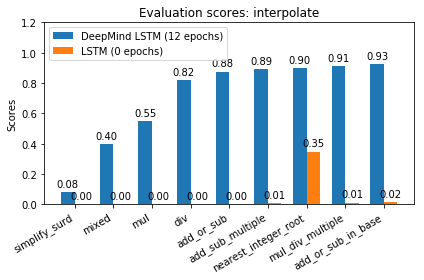

In [38]:
for epoch, job_id in enumerate(job_ids):
    model_path = Path('../src/models/'  + job_id)
    lstm_eval = EvaluateLSTMWithAttention(model_path)
    print('EPOCH', epoch + 1)
    exp_name = 'LSTM (%i epochs)' % (epoch+1)
    res, res_dm = evaluate_on_dataset(lstm_eval, input_texts, target_texts, 
                                      ['DeepMind LSTM (12 epochs)', exp_name],
                                      res_dm_att_lstm_inter, test_set='interpolate')

EPOCH 0


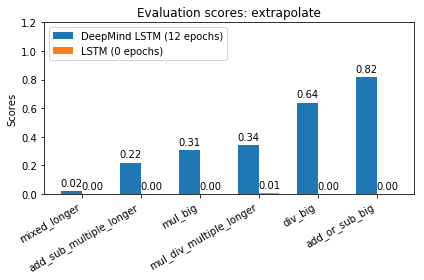

In [39]:
for epoch, job_id in enumerate(job_ids):
    model_path = Path('../src/models/'  + job_id)
    lstm_eval = EvaluateLSTMWithAttention(model_path)
    print('EPOCH', epoch+1)
    exp_name = 'LSTM (%i epochs)' % (epoch+1)
    res, res_dm = evaluate_on_dataset(lstm_eval, input_texts, target_texts, 
                                      ['DeepMind LSTM (12 epochs)', exp_name],
                                      res_dm_att_lstm_extra, test_set='extrapolate')